In [3]:
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras.utils import image_dataset_from_directory
import pathlib

# Transfer learning with Xception Model

Xception is a deep convolutional neural network architecture that involves Depthwise Separable Convolutions. This network was introduced Francois Chollet who works at Google, Inc. 

Read train and validation data from directory

In [25]:
data_folder = pathlib.Path('../../facial_expression_recognition/images')
target_img_size = (71, 71)

train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size= target_img_size,
    label_mode='categorical',
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size= target_img_size,
    label_mode='categorical',
    batch_size=32)

Found 28821 files belonging to 7 classes.
Found 7066 files belonging to 7 classes.


Transform images to contain as if they have 3 color channels (rgb). Because Xception model requires input images with 3 channels.

In [5]:
for images, labels in train_dataset:
    images = np.stack((images, ) * 3, axis=-1)


In [6]:
for images, labels in validation_dataset:
   images = np.stack((images, ) * 3, axis=-1)

Freeeze all layers, and exclude top layer.

In [7]:
conv_base = keras.applications.Xception(
    weights="imagenet",
    include_top=False)

In [8]:

# Freeze all layers
conv_base.trainable = False
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                        

In [9]:
from keras import layers

inputs = keras.Input(shape=(71, 71, 3))
x = tf.keras.applications.xception.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(7, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [39]:
opt = keras.optimizers.Nadam(learning_rate=1e-5)
model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/xception_transfer_image_resized.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
901/901 [==============================] - 21s 17ms/step - loss: 1.7274 - accuracy: 0.3522 - val_loss: 1.5322 - val_accuracy: 0.4236
Epoch 2/50
901/901 [==============================] - 15s 17ms/step - loss: 1.5445 - accuracy: 0.4179 - val_loss: 1.4938 - val_accuracy: 0.4410
Epoch 3/50
901/901 [==============================] - 15s 16ms/step - loss: 1.4751 - accuracy: 0.4427 - val_loss: 1.4535 - val_accuracy: 0.4533
Epoch 4/50
901/901 [==============================] - 14s 16ms/step - loss: 1.4299 - accuracy: 0.4638 - val_loss: 1.4709 - val_accuracy: 0.4502
Epoch 5/50
901/901 [==============================] - 14s 16ms/step - loss: 1.3909 - accuracy: 0.4766 - val_loss: 1.4500 - val_accuracy: 0.4605
Epoch 6/50
901/901 [==============================] - 15s 16ms/step - loss: 1.3688 - accuracy: 0.4851 - val_loss: 1.4336 - val_accuracy: 0.4680
Epoch 7/50
901/901 [==============================] - 14s 16ms/step - loss: 1.3459 - accuracy: 0.4935 - val_loss: 1.4402 - val_accuracy:

## Use Xception Model with unfreeze the base model, fine tuning

In [10]:
conv_base.trainable = True

In [11]:
opt = keras.optimizers.Nadam(learning_rate=1e-5)
model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/xception_transfer_fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
901/901 [==============================] - 68s 60ms/step - loss: 1.6881 - accuracy: 0.3429 - val_loss: 1.4973 - val_accuracy: 0.4329
Epoch 2/50
901/901 [==============================] - 55s 61ms/step - loss: 1.4038 - accuracy: 0.4649 - val_loss: 1.3670 - val_accuracy: 0.4863
Epoch 3/50
901/901 [==============================] - 55s 60ms/step - loss: 1.2519 - accuracy: 0.5272 - val_loss: 1.4567 - val_accuracy: 0.5098
Epoch 4/50
901/901 [==============================] - 55s 61ms/step - loss: 1.1021 - accuracy: 0.5820 - val_loss: 1.3815 - val_accuracy: 0.5250
Epoch 5/50
901/901 [==============================] - 57s 64ms/step - loss: 0.9718 - accuracy: 0.6366 - val_loss: 1.3579 - val_accuracy: 0.5401
Epoch 6/50
901/901 [==============================] - 55s 60ms/step - loss: 0.8439 - accuracy: 0.6855 - val_loss: 1.3885 - val_accuracy: 0.5444
Epoch 7/50
901/901 [==============================] - 54s 60ms/step - loss: 0.7185 - accuracy: 0.7368 - val_loss: 1.4405 - val_accuracy:

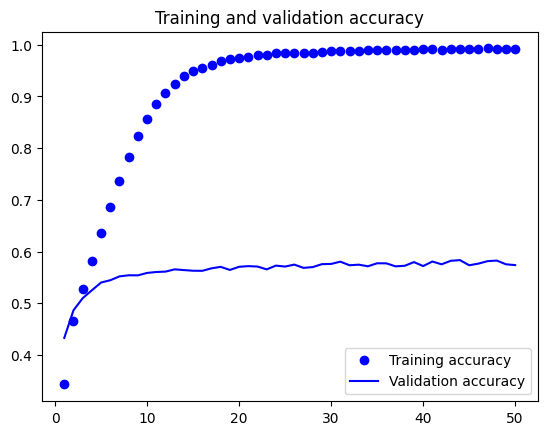

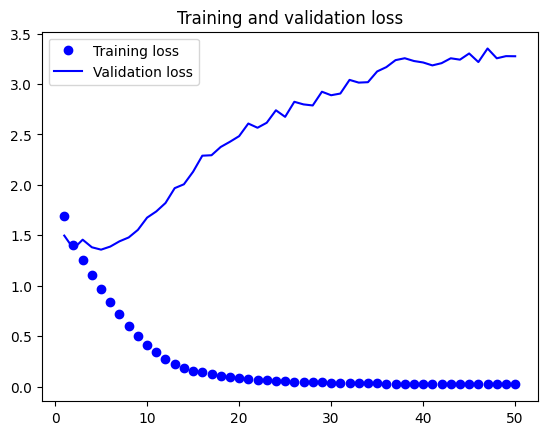

In [12]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

The training accuracy is 99%, the validation accuracy is 57%. The training accuracy seems good, but validation accuracy is still around 57%. Train data overfitted to the model.

Compute and draw confusion matrix for the Xception Model 

In [37]:
class_names = {
    '0': 'angry',
    '1': 'disgust',
    '2': 'fear',
    '3': 'happy',
    '4': 'sad',
    '5': 'suprise',
    '6': 'neutral',
}

Collect labels of validation samples into a numpy array from BatchDataset

In [41]:
labels =  np.array([])
for x, y in validation_dataset:
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

In [42]:
labels

array([5., 5., 0., ..., 4., 4., 5.])

In [43]:

predictions = model.predict(validation_dataset)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = labels
names = class_names.values()


221/221 [==============================] - 2s 11ms/step


Calculate and draw confusion matrix of the validation predicted values.

[[132   7 159 258 125 155 124]
 [  9   0  23  36  19  18   6]
 [158  16 157 280 140 157 110]
 [257  31 264 473 266 293 241]
 [194   9 178 324 189 182 140]
 [173  13 167 311 170 187 118]
 [132  16 115 203 113 128  90]]


<Figure size 640x480 with 0 Axes>

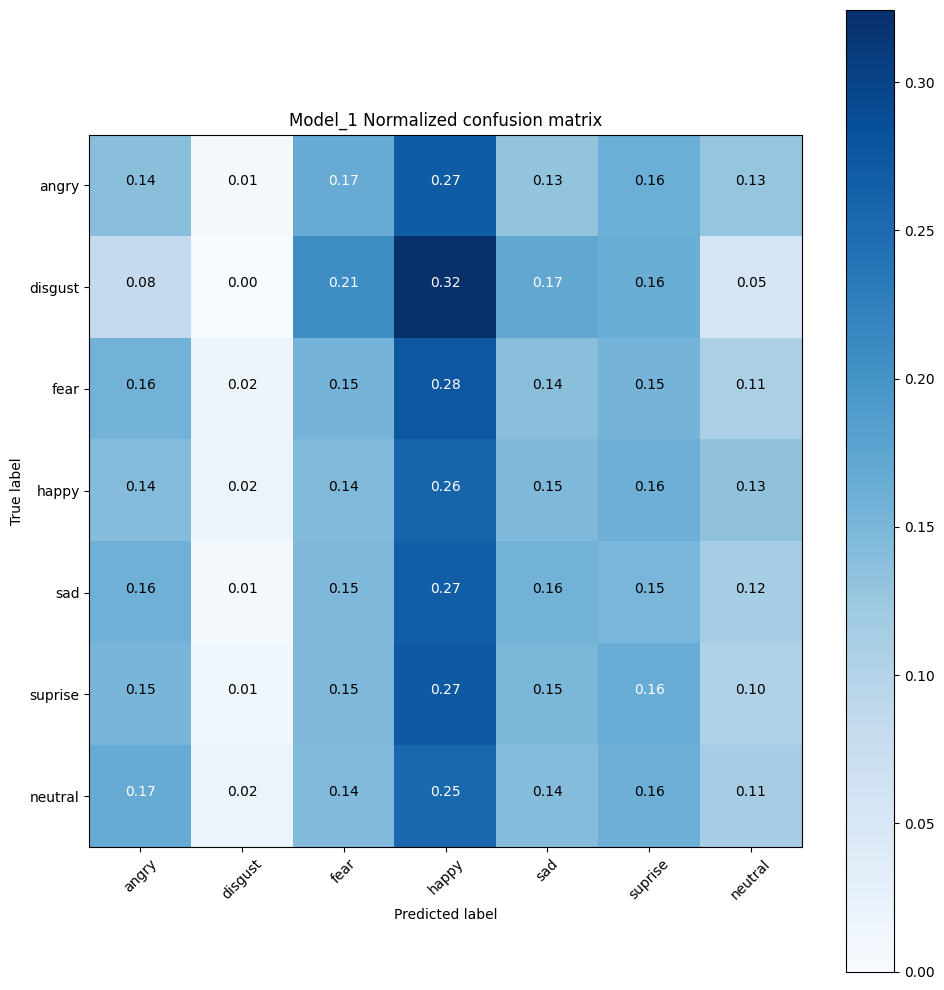

In [40]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
print(cnf_matrix)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=names, title='Model_1 Normalized confusion matrix')

The model reflects the imbalance of the data. Because number of images with label 'Happy' are the most, all different images tend to be classified as Happy.